In [1]:
import numpy as np 
import urdf2casadi.urdfparser as u2c
from urdf2casadi.geometry import plucker
from urdf_parser_py.urdf import URDF, Pose
#import PyKDL as kdl
#import kdl_parser.kdl_parser_py.kdl_parser_py.urdf as kdlurdf
from timeit import Timer, timeit, repeat
import rbdl
import pybullet as pb


In [2]:
def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.0
        
def average(lst): 
    return sum(lst) / len(lst) 

#def C_kdl_func():
#    for j in range(njoints):
#        q_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        #qdot_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

#    kdl.ChainDynParam(kdlmodel, g_kdl).JntToCoriolis(q_kdl, qdot_kdl, C_kdl)

#timeit_kdl = repeat("M_kdl_func()", setup = "from __main__ import M_kdl_func", repeat = nrepeat, number = nitr)
#mintime_kdl[i] = min(timeit_kdl)
#mediantime_kdl[i] = median(timeit_kdl)
#averagetime_kdl[i] = average(timeit_kdl)

def aba_u2c_func():   
    for j in range(njoints):
        q_none = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    aba_u2c(q_none, qdot_none)
    
def crba_u2c_func():
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
    
    crba_u2c(q_none, qdot_none)
    
    
def fd_rbdl_func():
    for j in range(njoints):
        q_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    rbdl.ForwardDynamics(rbdlmodel, q_np, qdot_np, tau_np, qddot_np)



In [5]:
#pbmodel = pb.loadURDF("pantilt.urdf")
sim = pb.connect(pb.DIRECT)
#pbmodel = pb.loadURDF("/urdf4timing/1dof.urdf")
ndofs = 12
urdf_nr = list(range(ndofs + 1))
urdf_nr.pop(0)

#storage for timing data

mediantime_u2c_aba = [None]*ndofs
mediantime_rbdl = [None]*ndofs
mediantime_u2c_crba = [None]*ndofs
#mintime_kdl = [None]*ndofs
mintime_u2c_aba = [None]*ndofs
mintime_rbdl = [None]*ndofs
mintime_u2c_crba = [None]*ndofs
#averagetime_kdl = [None]*ndofs
averagetime_u2c_aba = [None]*ndofs
averagetime_rbdl = [None]*ndofs
averagetime_u2c_crba = [None]*ndofs


nitr = 50000
nrepeat = 10
    
for i in range(ndofs):    
    print i
    #path_to_urdf = "/home/lillmaria/urdf2casadi/examples/timing/urdf4timing/" + str(urdf_nr[i]) + "dof.urdf"
    path_to_urdf = str(urdf_nr[i]) + "dof.urdf"
    end_link = "link" + str(urdf_nr[i])
    root = 'base_link'
    tip = end_link
    
    #ok, kdl_tree = kdlurdf.treeFromFile(path_to_urdf)
    #kdlmodel = kdl_tree.getChain(root,tip)
    
    rbdlmodel = rbdl.loadModel(path_to_urdf)
    pbmodel = pb.loadURDF(path_to_urdf, useFixedBase=True)
    asd = u2c.URDFparser()
    robot_desc = asd.from_file(path_to_urdf)
    
    jlist, names, qmax, qmin = asd.get_joint_info(root, tip)
    njoints = len(jlist)

    #g_kdl = kdl.Vector()
    #M_kdl = kdl.JntSpaceInertiaMatrix(njoints)
    
    #rbdl declarations
    q_np = np.zeros(njoints)
    qdot_np = np.zeros(njoints)
    qddot_np = np.zeros(njoints)
    tau_np = np.zeros(njoints)
    
    #kdl declatations
    #q_kdl = kdl.JntArray(njoints)
    #qdot_kdl = kdl.JntArray(njoints)
    
    #u2c and pybullet declarations
    q_none = [None]*njoints
    qdot_none = [None]*njoints
    C_pb = [None]*njoints
    
    tau = []
    for i in range(njoints):
        tau.append(0.)
        
    #er det gravity sin feil?    
    gravity = [0, 0, -9.81]
    
    aba_u2c = asd.get_forward_dynamics_ABA(root, tip, tau)
    timeit_u2c_aba = repeat("aba_u2c_func()", setup = "from __main__ import aba_u2c_func", repeat = nrepeat, number = nitr)
    mintime_u2c_aba[i] = min(timeit_u2c_aba)
    mediantime_u2c_aba[i] = median(timeit_u2c_aba)
    averagetime_u2c_aba[i] = average(timeit_u2c_aba)
    
    crba_u2c = asd.get_forward_dynamics_CRBA(root, tip, tau)
    timeit_crba = repeat("crba_u2c_func()", setup = "from __main__ import crba_u2c_func", repeat = nrepeat, number = nitr)
    mintime_u2c_crba[i] = min(timeit_crba)
    mediantime_u2c_crba[i] = median(timeit_crba)
    averagetime_u2c_crba[i] = average(timeit_crba)
    
    timeit_rbdl = repeat("fd_rbdl_func()", setup = "from __main__ import fd_rbdl_func", repeat = nrepeat, number = nitr)
    mintime_rbdl[i] = min(timeit_rbdl)
    mediantime_rbdl[i] = median(timeit_rbdl)
    averagetime_rbdl[i] = average(timeit_rbdl)
    
    

0
1dof.urdf
1
2dof.urdf
2
3dof.urdf
3
4dof.urdf
4
5dof.urdf
5
6dof.urdf
6
7dof.urdf
7
8dof.urdf
8
9dof.urdf
9
10dof.urdf
10
11dof.urdf
11
12dof.urdf


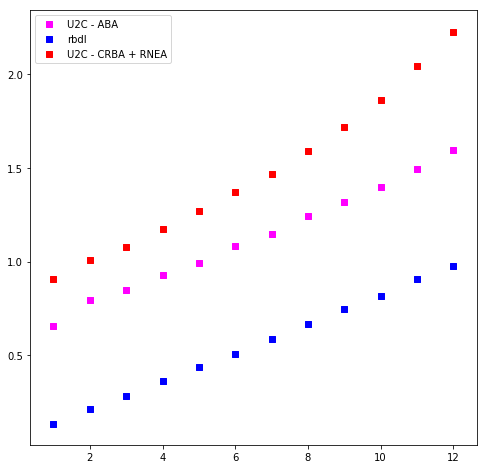

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

joint_nr = list(range(ndofs + 1))
joint_nr.pop(0)
med_fig = plt.figure(figsize = (8, 8))
#plt.scatter(joint_nr, mediantime_kdl, c='r', marker='x', label='kdl')
plt.scatter(joint_nr, mediantime_u2c_aba, c='fuchsia', marker='s', label='U2C - ABA')
plt.scatter(joint_nr, mediantime_rbdl, c='b', marker='s', label='rbdl')
plt.scatter(joint_nr, mediantime_u2c_crba, c='r', marker='s', label='U2C - CRBA + RNEA')
plt.legend(loc='upper left')
med_fig.show()

[Text(0,0,'U2C - ABA'), Text(0,0,'U2C - CRBA + RNEA'), Text(0,0,'RBDL')]

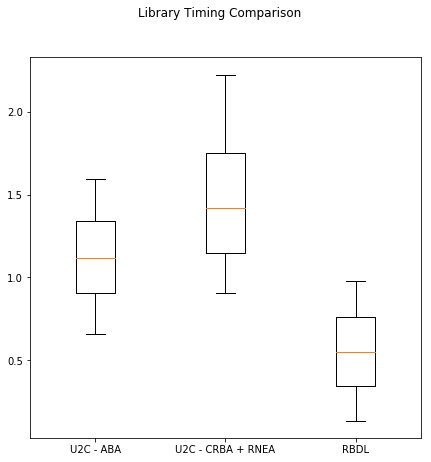

In [9]:
timing_scores = [mediantime_u2c_aba, mediantime_u2c_crba, mediantime_rbdl]
names = ["U2C - ABA", "U2C - CRBA + RNEA", "RBDL"]
boxplot = plt.figure(figsize = (7, 7))
boxplot.suptitle("Library Timing Comparison")
ax = boxplot.add_subplot(111)
ax.boxplot(timing_scores)
#plt.boxplot(timing_scores)
ax.set_xticklabels(names)
